### Import Libraries

In [64]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


### Define Constants

In [39]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Prepare Traning Data

In [45]:
filenames = os.listdir("E:\\study\\simpli\\ML_Vignesh_24Apr_30May\\Mercedes-benz-dataset\\DL_project_data\\input\\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [46]:
df.tail()

,category,filename
35,1,dog.5.jpg
36,1,dog.6.jpg
37,1,dog.7.jpg
38,1,dog.8.jpg
39,1,dog.9.jpg


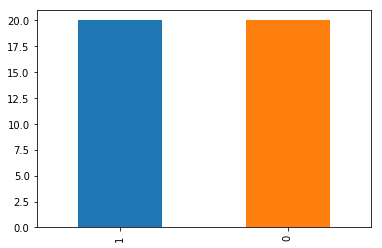

In [47]:
df['category'].value_counts().plot.bar()

### See sample image

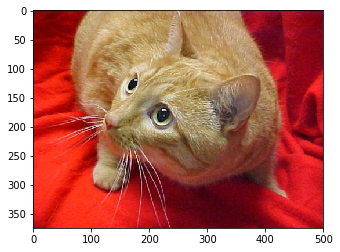

In [48]:
sample = random.choice(filenames)
image = load_img("E:\\study\\simpli\\ML_Vignesh_24Apr_30May\\Mercedes-benz-dataset\\DL_project_data\\input\\train\\"+sample)
plt.imshow(image)

### Build Model

### Input layer 

● Convolutional layer 1 with 32 filters of kernel size[5,5] 

● Pooling layer 1 with pool size[2,2] and stride 2 

● Convolutional layer 2 with 64 filters of kernel size[5,5] 

● Pooling layer 2 with pool size[2,2] and stride 2 

● Dense layer whose output size is fixed in the hyper parameter: fc_size=32 

● Dropout layer with dropout probability 0.4 

In [49]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [58]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [59]:
earlystop = EarlyStopping(patience=10)

In [60]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [61]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare data

In [50]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [51]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

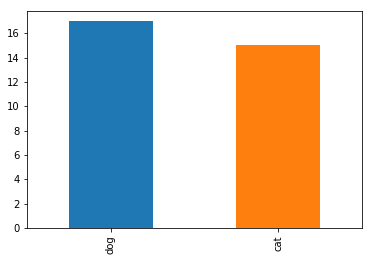

In [52]:
train_df['category'].value_counts().plot.bar() 

In [53]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Traning Generator

In [54]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "E:\\study\\simpli\\ML_Vignesh_24Apr_30May\\Mercedes-benz-dataset\\DL_project_data\\input\\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 32 validated image filenames belonging to 2 classes.


### Validation Generator¶

In [55]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
     "E:\\study\\simpli\\ML_Vignesh_24Apr_30May\\Mercedes-benz-dataset\\DL_project_data\\input\\test",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


C:\Users\user\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 8 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [56]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
  "E:\\study\\simpli\\ML_Vignesh_24Apr_30May\\Mercedes-benz-dataset\\DL_project_data\\input\\test",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 0 validated image filenames belonging to 0 classes.


C:\Users\user\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


### Fit Model

In [62]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
2/2 [==============================] - 6s 3s/step - loss: 0.9660 - accuracy: 0.4706
Epoch 2/50


C:\Users\user\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\user\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2/2 [==============================] - 2s 904ms/step - loss: 3.7760 - accuracy: 0.6000
Epoch 3/50
2/2 [==============================] - 1s 579ms/step - loss: 3.7795 - accuracy: 0.6471
Epoch 4/50
2/2 [==============================] - 2s 909ms/step - loss: 0.6924 - accuracy: 0.8333
Epoch 5/50
2/2 [==============================] - 1s 302ms/step - loss: 3.8416 - accuracy: 0.0000e+00
Epoch 6/50
2/2 [==============================] - 2s 936ms/step - loss: 1.1938 - accuracy: 0.6667
Epoch 7/50
2/2 [==============================] - 2s 914ms/step - loss: 0.5417 - accuracy: 0.8000
Epoch 8/50
2/2 [==============================] - 1s 306ms/step - loss: 0.9173 - accuracy: 0.7500
Epoch 9/50
2/2 [==============================] - 2s 939ms/step - loss: 0.8791 - accuracy: 0.7333
Epoch 10/50
2/2 [==============================] - 1s 609ms/step - loss: 0.7785 - accuracy: 0.7647
Epoch 11/50
2/2 [==============================] - 2s 997ms/step - loss: 0.4369 - accuracy: 0.9333
Epoch 12/50
2/2 [========

### Save Model

In [63]:
model.save_weights("CNN_Pet_Prediction_model.h5")